# 下載範例數據檔

# Install Tensorflow 2.0

# Build Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
assert tf.__version__ == '2.0.0'
tf.keras.backend.set_image_data_format('channels_last')

In [4]:
# Specify which GPU(s) to use
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Or 1, 2, 3, etc. other than 0

from network import Embedder, Generator, Discriminator
from loss import get_lossD, get_lossEG, vgg

In [5]:
from data import VoxCelebDataset, DatasetGen
root = "../data/"
K = 8
B = 4
dataset = VoxCelebDataset(root, K=K, img_size=128)
datagen = DatasetGen(dataset, batch_size=B)

file_idx, source_landmark, target_frame, x, y = next(iter(datagen))
#file_idx, source_landmark.shape, target_frame.shape, x.shape, y.shape

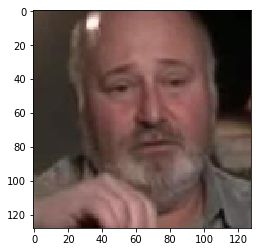

In [6]:
# try to draw one
x_ = dataset.transpose_for_plotting(target_frame)
plt.imshow(x_)

In [7]:
# build model
E = Embedder()
G = Generator()
D = Discriminator(B)

In [8]:
# dummy forward
x = tf.random.normal((7, 128, 128, 3))
y = tf.random.normal((7, 128, 128, 3))
c = tf.fill((7, 1),1.0)
c_categ = tf.keras.utils.to_categorical(c, num_classes=B) 
emb = tf.random.normal((7, 512))
E(x,y).shape, G(y,emb).shape, D(x,y,c_categ).shape

(TensorShape([7, 512]), TensorShape([7, 128, 128, 3]), TensorShape([7, 1]))

# Train

In [9]:
from loss import l1_loss, get_lossD, get_lossEG

In [10]:
@tf.function
def train_step_justEG(source_landmark, target_frame, 
                      x, y, c_categ, optimizer_E_G, optimizer_D, file_idx):

    with tf.GradientTape() as tape:
        emb_hat = E(x,y)
        emb_mean = tf.math.reduce_mean(emb_hat, 0, keepdims=True)
        target_frame_ = G(source_landmark, emb_mean)
        loss = l1_loss(target_frame_, target_frame)
        tf.print(f"file_idx[{file_idx}] loss_EG (l1):", loss )
    
    vars_ = E.trainable_variables+G.trainable_variables
    grads = tape.gradient(loss, vars_ )
    
    # update E G
    optimizer_E_G.apply_gradients(zip(grads, vars_ ))
        

In [11]:
@tf.function
def train_step(source_landmark, target_frame, 
               x, y, c_categ, optimizer_E_G, optimizer_D, file_idx):
    
    with tf.GradientTape() as tape:
        emb_hat = E(x,y)
        emb_mean = tf.math.reduce_mean(emb_hat, 0, keepdims=True)
        target_frame_ = G(source_landmark, emb_mean)
        r_x = D(target_frame,source_landmark, c_categ)
        r_x_hat = D(target_frame_,source_landmark, c_categ)
        loss_EG = get_lossEG(target_frame_ , target_frame , r_x_hat)
        loss_D = get_lossD(r_x, r_x_hat)
        loss = loss_EG + loss_D
        tf.print(f"file_idx[{file_idx}] loss:", loss, "loss_EG:", loss_EG, "loss_D:", loss_D )
    
    vars_ = D.trainable_variables+E.trainable_variables+G.trainable_variables
    grads = tape.gradient(loss, vars_ )
    
    # update E G
    n_varEG = len(E.trainable_variables+G.trainable_variables)
    varsEG = vars_[-n_varEG:]
    gradsEG = grads[-n_varEG:]
    optimizer_E_G.apply_gradients(zip(gradsEG, varsEG ))

    # update D
    n_varD = len(D.trainable_variables)
    varsD = vars_[:n_varD]
    gradsD = grads[:n_varD]
    optimizer_D.apply_gradients(zip(gradsD, varsD ))   
    

In [12]:
def train(epochs=50, this_epo=0, justEG=False, 
          n_file=B, save_freq=50):
    loss_fn = train_step_justEG if justEG else train_step
    for epoch in range(epochs):
        print (f'Epoch [{epoch}]')
        for batch_no, (file_idx, source_landmark, target_frame, x, y) in enumerate(datagen):
            c = tf.fill((1, 1),float(file_idx))
            c_categ = tf.keras.utils.to_categorical(c, num_classes=B) 
            target_frame = target_frame[None,...]
            source_landmark = source_landmark[None,...]
            loss = loss_fn(source_landmark, target_frame, 
                           x, y, c_categ, optimizer_E_G, optimizer_D, file_idx)
            if batch_no ==  n_file-1: break
                
        # save weight
        if epoch>0 and (epoch%save_freq==0 or epoch==epochs-1):
            current_epo = this_epo + epoch + 1
            E.save_weights(f'model/E_{current_epo}.h5')
            G.save_weights(f'model/G_{current_epo}.h5')
            if not justEG: D.save_weights(f'model/D_{current_epo}.h5')
    
    print (f'Epoch {current_epo} finished')
   

In [13]:
optimizer_E_G = tf.keras.optimizers.RMSprop(learning_rate=5e-5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=2e-4)
datagen = DatasetGen(dataset, batch_size=B)

In [20]:
# train !
hist_ = train(epochs=3, this_epo=0, justEG=False)

Epoch [0]
file_idx[0] loss: 1.04675961 loss_EG: -14.303956 loss_D: 15.3507156
file_idx[1] loss: 1.05581284 loss_EG: -12.075367 loss_D: 13.1311798
file_idx[2] loss: 1.04602814 loss_EG: -11.3614864 loss_D: 12.4075146
file_idx[3] loss: 1.05556655 loss_EG: -0.993742287 loss_D: 2.04930878
Epoch [1]
file_idx[0] loss: 1.0464592 loss_EG: -14.2700939 loss_D: 15.3165531
file_idx[1] loss: 1.04562473 loss_EG: -12.1707602 loss_D: 13.2163849
file_idx[2] loss: 1.04662991 loss_EG: -11.0831652 loss_D: 12.1297951
file_idx[3] loss: 1.05465174 loss_EG: -6.44885731 loss_D: 7.50350904
Epoch [2]
file_idx[0] loss: 1.04561138 loss_EG: -14.1141729 loss_D: 15.1597843
file_idx[1] loss: 1.04539394 loss_EG: -11.7899227 loss_D: 12.8353167
file_idx[2] loss: 1.05020332 loss_EG: -10.6365776 loss_D: 11.6867809
file_idx[3] loss: 1.05165577 loss_EG: -9.70472908 loss_D: 10.7563848
Epoch 3 finished


0


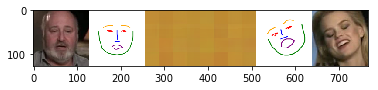

In [21]:
file_idx, source_landmark, target_frame, x, y = next(iter(datagen))
target_frame = target_frame[None,...]
source_landmark = source_landmark[None,...]
emb_hat = E(target_frame,source_landmark)
target_frame_ = G(source_landmark, emb_hat)

file_idx2, source_landmark2, target_frame2, x2, y2 = next(iter(datagen))
target_frame2 = target_frame2[None,...]
source_landmark2 = source_landmark2[None,...]
target_frame2_ = G(source_landmark2, emb_hat)

print(file_idx)
plt.imshow(np.concatenate(( target_frame[0], source_landmark[0], target_frame_[0], 
                           target_frame2_[0], source_landmark2[0], target_frame2[0] ), 1 ) )
plt.show()


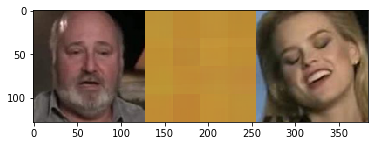

In [22]:
plt.imshow(np.concatenate(( target_frame[0],  
                           target_frame2_[0], target_frame2[0] ), 1 ) )
plt.show()